# Metropolis algorithm in the Ising model

##### Plotting utilities

In [1]:
extension(path::String) = match(r"\.[A-Za-z0-9]+$", path).match
    
struct Gnuplot
    filename::String
    ext::String
    f::Pipe
    p::Base.Process
    function Gnuplot(filename::String)
        f,p = open(`gnuplot`,"w")
        ext = extension(filename)
        if ext == ".svg"
            write(f,"set terminal epslatex standalone size 10,10cm\\
                    color background 'white' lw 3 font ',12'\\
                    header '\\usepackage[utf8]{inputenc} \\usepackage{amsmath}';
                    set output 'gptemp.tex'; set colorsequence podo;")
        elseif ext == ".png"
            write(f,"set terminal png;
                    set output '$filename';
                    set colorsequence podo;")
        elseif ext == ".gif"
            write(f,"set terminal gif animate delay 100;
                    set output '$filename';
                    set colorsequence podo;")
        end
        return new(filename,ext,f,p)
    end
end
function plot(gp::Gnuplot)
    close(gp.f)
    wait(gp.p.closenotify)
    if gp.ext == ".svg"
        run(pipeline(`pdflatex gptemp.tex`, stdout=DevNull))
        run(`pdf2svg gptemp.pdf $(gp.filename)`)
        run(`find -x . -name gptemp\* -delete`)
        display("image/svg+xml",readstring("./$(gp.filename)"))
    elseif gp.ext == ".png"
        display("image/png",read("./$(gp.filename)"))
    elseif gp.ext == ".gif"
        display("image/gif",read("./$(gp.filename)"))          
    end
end

plot (generic function with 1 method)

## Representing the lattice.

A Lattice will consist of $\sigma_i$, a vector of spins, and $\{v_i\}$ representing the list of neighbours of the $i$-th spin. Neighbours will depend on a given geometry.

In [2]:
mutable struct Lattice
    spins::Vector{Int}
    neighbours::Vector{Vector{Int}}
    J::Float64
    h::Float64
    M::Float64
    H::Float64
    
    function Lattice(J::Float64, h::Float64, nSpins::Int, geometry::Function, seed::Int)
        srand(seed) # Get the same random lattice every time.
        
        spins = [ rand([-1,1]) for i in 1:nSpins ]
        neighbours = geometry(nSpins)
        
        H = 0; M = 0
        for i in 1:nSpins
            for j in neighbours[i]
                if j < i; continue; end # repeated pairs.
                H += spins[i] * spins[j]
            end
            M += spins[i]
        end
        H = -J*H - h*M # Energy
        M = M/nSpins # Magnetization
        
        return new(spins,neighbours,J,h,M,H)
    end
end

## Different geometries

We will work with a square lattice, an hexagonal lattice, and a triangular lattice.

In [3]:
periodic(x,n) = mod(x-1,n) + 1 # Periodic conditions.
linear(i,j,n) = (i-1)*n + j # Matrix to linear array mapping.

function square(nSpins::Int)
    neighbours::Vector{Vector{Int}} = [ [] for i in 1:nSpins ]
    n = sqrt(nSpins)
    k = 1
    for i in 1:n, j in 1:n
        push!(neighbours[k], linear(i,periodic(j+1,n),n)) # Right neighbour
        push!(neighbours[k], linear(i,periodic(j-1,n),n)) # Left neighbour
        push!(neighbours[k], linear(periodic(i+1,n),j,n)) # Top neighbour
        push!(neighbours[k], linear(periodic(i-1,n),j,n)) # Bottom neighbour
        k += 1
    end
    return neighbours
end

square (generic function with 1 method)

## Updating the lattice, a Monte Carlo process.

The probability that the lattice will change its state (by the process of randomly altering a single spin) will be ruled by the Boltzmann distribution.

$$ p = \exp\left(-\frac{H_2 - H_1}{k_B T}\right) $$

Since we are changing only one spin inside the lattice, it's more efficient to calculate just the energy difference.

$$ \Delta H =  H_1 - H_2 = -2\sigma_k\left(J\sum_{\langle i,k\rangle}\sigma_i + h\right) $$

The same goes for the magnetization.

$$ M_1 - M_2 = \frac{2\sigma_k}{N}$$

Function ```monteCarlo!``` takes all of this into account.

In [4]:
function monteCarlo!(l::Lattice, T::Float64)
    k = rand(1:length(l.spins))
    
    dH = 0 # H1- H2
    for i in l.neighbours[k]
        dH += l.spins[i]
    end
    dH = -2*l.spins[k]*(l.J*dH + l.h)
    
    Ht = l.H - dH # trial energy
    Mt = l.M - 2*l.spins[k]/length(l.spins) # trial magnetization
    
    p = exp(dH/T)
    if p > rand()
        # trial step accepted
        l.H = Ht
        l.M = Mt
        l.spins[k] *= -1
    end
end

monteCarlo! (generic function with 1 method)

## Thermalization for different temperatures

Updating the lattice for a number of steps will make the system get to an equilibrium state.

### Square lattice.

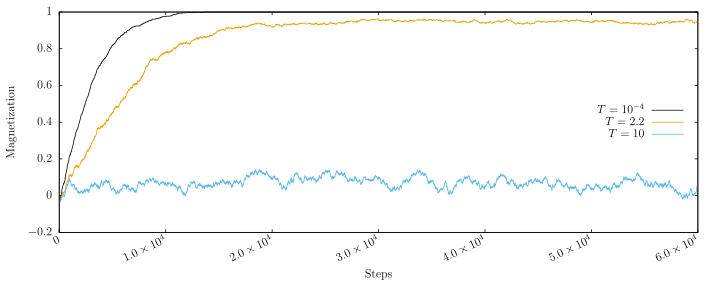

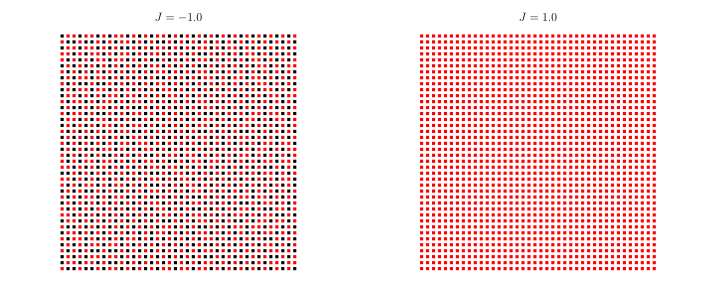

In [5]:
J = 1.0; h = 0.5; nSpins = 40*40; seed = 150


gp = Gnuplot("thermalization.svg")
write(gp.f, "set xlabel 'Steps'; set ylabel 'Magnetization';
    set key center right; set format x '\$%1.1t\\times 10^%T\$'; set xtics add ('0' 0) rotate by 25 right
    plot '-' w l t '\$T = 10^{-4}\$', '' w l t '\$T = 2.2\$', '' w l t '\$T = 10\$';\n")
steps = 60000
temperatures = (1e-4, 2.2, 10.0)
for T in temperatures
    l = Lattice(J,h,nSpins,square,seed)
    for i in 1:steps
        if mod(i,10) == 0; write(gp.f, "$i $(l.M)\n"); end
        monteCarlo!(l,T)
    end
    write(gp.f,"e\n\n")
end
plot(gp)


gp = Gnuplot("lattice.svg")
write(gp.f, "set notics; set noborder; unset colorbox; set size square;
            set palette defined (-1 'black', 1 'red');
            set cbrange [-1:1];
            set multiplot layout 1,2;")
T=1e-4
n = sqrt(nSpins)
for J in [-1.0,1.0]
    l = Lattice(J,h,nSpins,square,seed)
    for i=1:steps; monteCarlo!(l,T); end
    write(gp.f, "set title '\$J = $J\$'; plot '-' u 1:2:3 w p pt 5 lc palette not\n")
    k = 1;
    for y in 1:n, x in 1:n
        write(gp.f, "$x $y $(l.spins[k])\n")
        k += 1
    end
    write(gp.f, "e\n")
end
plot(gp)

## Making measurements after thermalization

A cuasi-static process can be achieved by thermalizing the system every time we change it a little bit. We will slowly change the temperature and in each step of the process we will thermalize the system (we already saw in the result above the number of steps needed to achieve equilibrium). We will make it a two way process: we will increase the temperature of the system from $T_a$ to $T_b$ and then decrease it from $T_b$ to $T_a$.

In each step we can measure average magnetization, specific heat and magnetic susceptibility: $M(T),\, C_V(T),\, \chi(T)$. This is done by the function ```measure!```.

In [6]:
function measure!(l::Lattice, TRange::Vector{Float64}, nThermalization::Int, nMeasurements::Int)
    MM::Vector{Float64} = []
    CC::Vector{Float64} = []
    XX::Vector{Float64} = []
    for T in TRange
        for i = 1:nThermalization; monteCarlo!(l, T); end
        
        M = 0; H = 0
        M2 = 0; H2 = 0
        for i = 1:nMeasurements
            M += l.M
            H += l.H
            M2 += l.M*l.M
            H2 += l.H*l.H
            monteCarlo!(l, T)
        end
        # Mean
        M /= nMeasurements
        H /= nMeasurements
        # variance: mean of square minus square of mean
        M2 = M2/nMeasurements - M*M
        H2 = H2/nMeasurements - H*H
        T2 = T*T
        push!(MM, M)
        push!(CC, H2/T2)
        push!(XX, M2/T2)
    end
    return MM,CC,XX
end

measure! (generic function with 1 method)

### Square lattice

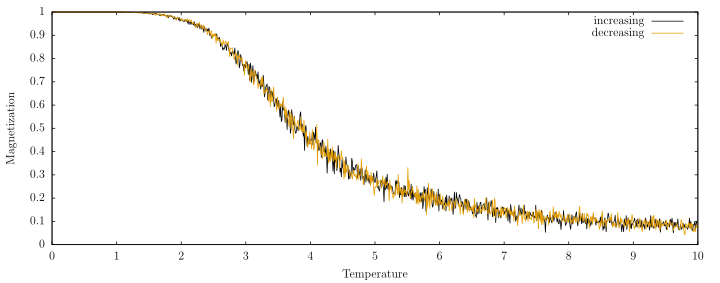

In [7]:
J = 1.0; h = 0.5; nSpins = 40*40; seed = 150
Ta = 1e-4; Tb = 10.0; dt = 1e-2

l = Lattice(J,h,nSpins,square,seed)

TInc = collect(Ta:dt:Tb)
dt *= -1
TDec = collect(Tb:dt:Ta)

MInc,CInc,XInc = measure!(l,TInc,20000,10000)
MDec,CDec,XDec = measure!(l,TDec,20000,10000)

# Plot of the average magnetization.
gp = Gnuplot("magnetization.svg")
write(gp.f,"set key top right; set xlabel 'Temperature'; set ylabel 'Magnetization';
        plot '-' u 1:2 w l t 'increasing', '' u 1:2 w l t 'decreasing';\n")
for i in eachindex(TInc)
    write(gp.f,"$(TInc[i]) $(MInc[i])\n")
end
write(gp.f, "e\n")
for i in eachindex(TDec)
    write(gp.f,"$(TDec[i]) $(MDec[i])\n")
end
plot(gp)

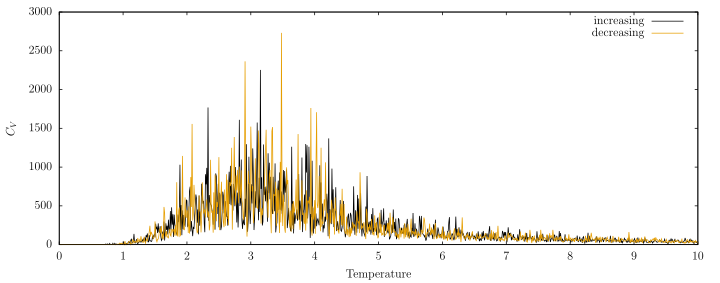

In [8]:
# Plot of the specific heat
gp = Gnuplot("specificHeat.svg")
write(gp.f,"set key top right; set xlabel 'Temperature'; set ylabel '\$C_V\$';
        plot '-' u 1:2 w l t 'increasing', '' u 1:2 w l t 'decreasing';\n")
for i in eachindex(TInc)
    write(gp.f,"$(TInc[i]) $(CInc[i])\n")
end
write(gp.f, "e\n")
for i in eachindex(TDec)
    write(gp.f,"$(TDec[i]) $(CDec[i])\n")
end
plot(gp)


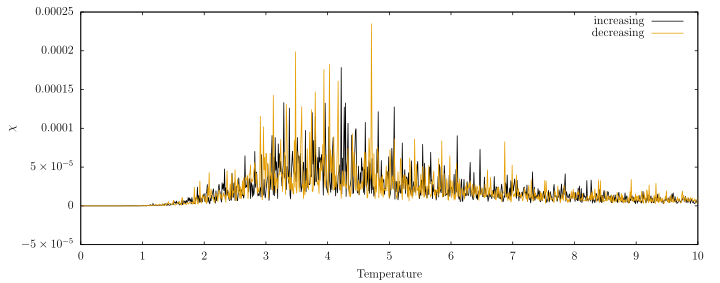

In [9]:
# Plot of the magnetic susceptibility
gp = Gnuplot("susceptibility.svg")
write(gp.f,"set key top right; set xlabel 'Temperature'; set ylabel '\$\\chi\$';
        plot '-' u 1:2 w l t 'increasing', '' u 1:2 w l t 'decreasing';\n")
for i in eachindex(TInc)
    write(gp.f,"$(TInc[i]) $(XInc[i])\n")
end
write(gp.f, "e\n")
for i in eachindex(TDec)
    write(gp.f,"$(TDec[i]) $(XDec[i])\n")
end
plot(gp)